<a href="https://colab.research.google.com/github/krishna1kok/DataCamp-Project/blob/main/books/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import data
## Data formatting as pandas dataframe

 This small section imports data from kaggle since it is already formatted.

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import KFold, StratifiedKFold


# This function prints a formatted table
def pretty_table(df=pd.DataFrame()):
  print(tabulate(df, headers='keys', tablefmt='psql'))

URL_DATA = (r'https://raw.githubusercontent.com/FidFenix/secom-pub-data/refs/heads/main/secom_etl.csv')
raw_data_df = pd.read_csv(URL_DATA, sep=';')
#raw_data_df = raw_data_df.replace('NaN', np.nan, regex=True)

#formatting dates
raw_data_df['Time'] = pd.to_datetime(raw_data_df['Time'], errors='coerce')

#Print
print("First 5 records:")
pretty_table(raw_data_df.head())

First 5 records:
+----+---------------------+---------+---------+---------+----------+--------+------+----------+--------+--------+---------+---------+--------+---------+-------+---------+---------+---------+--------+---------+---------+--------+----------+---------+----------+----------+--------+--------+--------+---------+--------+--------+--------+---------+--------+---------+---------+---------+---------+---------+---------+-------+-------+-------+---------+---------+---------+---------+--------+---------+-------+---------+---------+-------+-------+-------+-------+--------+--------+--------+----------+---------+---------+---------+---------+---------+---------+---------+--------+---------+-------+---------+---------+---------+---------+-------+---------+---------+---------+---------+---------+---------+---------+---------+--------+--------+-------+--------+--------+---------+--------+---------+---------+---------+---------+---------+---------+---------+-------+---------+---------+-

<ipython-input-33-891991d80717>:20: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  raw_data_df['Time'] = pd.to_datetime(raw_data_df['Time'], errors='coerce')


0.1 Shape of the raw_data_df

In [ ]:
print("raw_data_df shape (rows, columns):", raw_data_df.shape)

raw_data_df shape (rows, columns): (1567, 592)


# 1. General data information

## 1.1 Dates

### 1.1.1 Begin date and end date

In [ ]:
# beginning date and end date
begin_date, end_date = min(raw_data_df['Time']), max(raw_data_df['Time'])
print('Begin date: ', begin_date)
print('End date: ', end_date)

Begin date:  2008-07-19 11:55:00
End date:  2008-10-17 06:07:00


### 1.1.2 Datapoints per year and month

In [ ]:
# histogram
times = raw_data_df['Time'].groupby([raw_data_df['Time'].dt.year, raw_data_df['Time'].dt.month]).agg({'count'})
result_times_df = pd.DataFrame(times).rename(columns={'count': 'count datapoints'})
pretty_table(result_times_df)

+------------+--------------------+
|            |   count datapoints |
|------------+--------------------|
| (2008, 7)  |                 63 |
| (2008, 8)  |                555 |
| (2008, 9)  |                590 |
| (2008, 10) |                359 |
+------------+--------------------+


### 1.1.3 Failures per month

In [ ]:
failures_per_month = raw_data_df.groupby([raw_data_df['Time'].dt.year, raw_data_df['Time'].dt.month, raw_data_df['Pass/Fail']]).agg({'count'})
pretty_table(failures_per_month.iloc[:, :1])

+----------------+---------------------+
|                |   ('Time', 'count') |
|----------------+---------------------|
| (2008, 7, -1)  |                  49 |
| (2008, 7, 1)   |                  14 |
| (2008, 8, -1)  |                 504 |
| (2008, 8, 1)   |                  51 |
| (2008, 9, -1)  |                 573 |
| (2008, 9, 1)   |                  17 |
| (2008, 10, -1) |                 337 |
| (2008, 10, 1)  |                  22 |
+----------------+---------------------+


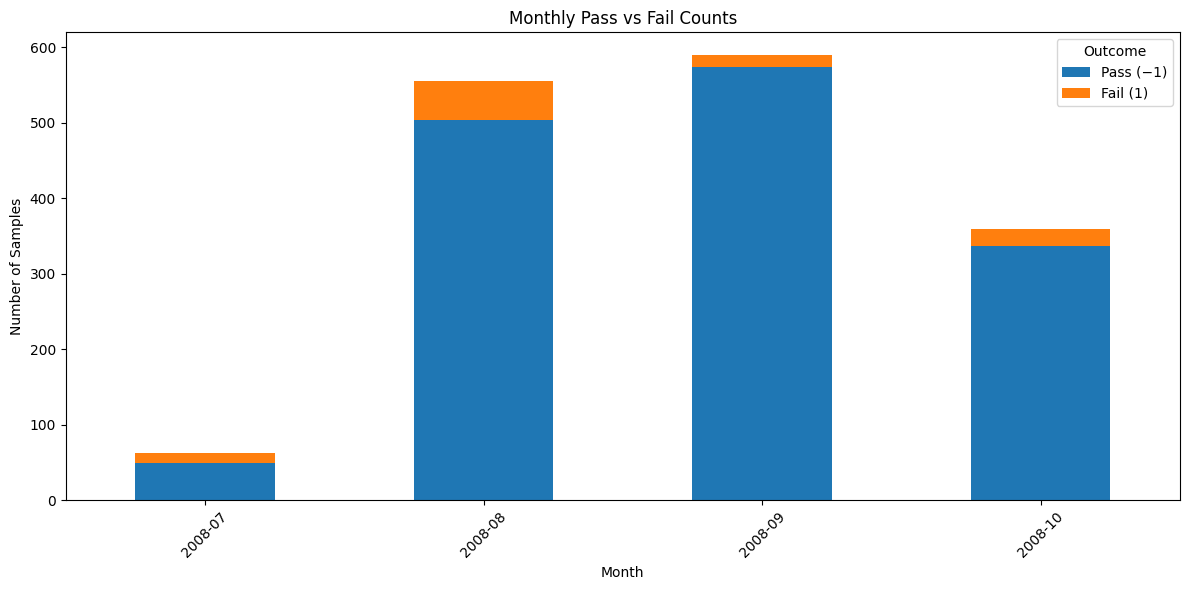

In [ ]:
# 1.1.3 Visualise Failures per Month (stacked bar)
import matplotlib.pyplot as plt

# Recompute counts per (year, month, Pass/Fail)
fpm = (
    raw_data_df
    .groupby([
        raw_data_df['Time'].dt.year.rename('year'),
        raw_data_df['Time'].dt.month.rename('month'),
        raw_data_df['Pass/Fail'].rename('pass_fail')
    ])
    .size()
    .to_frame('count')
    .reset_index()
)

# Pivot so pass_fail values become columns
counts = (
    fpm
    .pivot(index=['year','month'], columns='pass_fail', values='count')
    .fillna(0)
    .rename(columns={-1: 'Pass (−1)', 1: 'Fail (1)'})
)

# Format the index as "YYYY-MM"
counts.index = counts.index.map(lambda ym: f"{int(ym[0])}-{int(ym[1]):02d}")

# Plot stacked bar
fig, ax = plt.subplots(figsize=(12,6))
counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Samples')
ax.set_title('Monthly Pass vs Fail Counts')
ax.legend(title='Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-68-89d607d22393>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(fr['month'].astype(str), rotation=45)


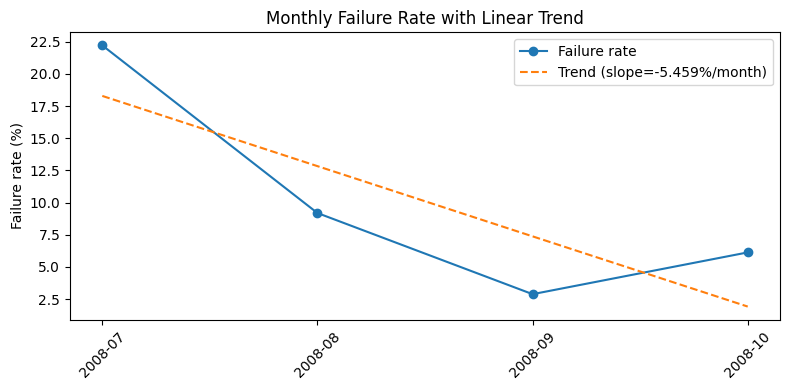

In [ ]:
# 1.1.4 Trend in monthly failure rate

import numpy as np
import matplotlib.pyplot as plt

# reuse 'fr' from Cell 2.19 (month, fail_rate_pct)
# if 'fr' isn’t in memory, recompute it:
fr = (
    raw_data_df
    .assign(month=raw_data_df['Time'].dt.to_period('M'))
    .groupby('month')['Pass/Fail']
    .apply(lambda x: (x==1).mean()*100)
    .to_frame('failure_rate_pct')
    .reset_index()
)

# convert month to numeric index for regression
fr['month_ordinal'] = np.arange(len(fr))
# linear fit
slope, intercept = np.polyfit(fr['month_ordinal'], fr['failure_rate_pct'], 1)

# plot failure rate + trend line
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(fr['month'].astype(str), fr['failure_rate_pct'], marker='o', label='Failure rate')
ax.plot(fr['month'].astype(str),
        intercept + slope*fr['month_ordinal'],
        color='C1', linestyle='--', label=f"Trend (slope={slope:.3f}%/month)")
ax.set_xticklabels(fr['month'].astype(str), rotation=45)
ax.set_ylabel('Failure rate (%)')
ax.set_title('Monthly Failure Rate with Linear Trend')
ax.legend()
plt.tight_layout()
plt.show()


# 2. Exploratory data analysis (EDA)

## 2.1 How many missing values?

### 2.2.1 Missing values per column

+----+---------------------+-----------------+-----------------------------+---------------------+
|    |   count_missing_val |   total_columns |   total_columns_relative(%) |   cumulative_sum(%) |
|----+---------------------+-----------------+-----------------------------+---------------------|
|  0 |                   6 |             100 |                   16.8919   |             16.8919 |
|  1 |                   1 |              92 |                   15.5405   |             32.4324 |
|  2 |                   2 |              84 |                   14.1892   |             46.6216 |
|  3 |                   0 |              54 |                    9.12162  |             55.7432 |
|  4 |                   9 |              48 |                    8.10811  |             63.8514 |
|  5 |                  24 |              43 |                    7.26351  |             71.1149 |
|  6 |                   3 |              24 |                    4.05405  |             75.1689 |
|  7 |    

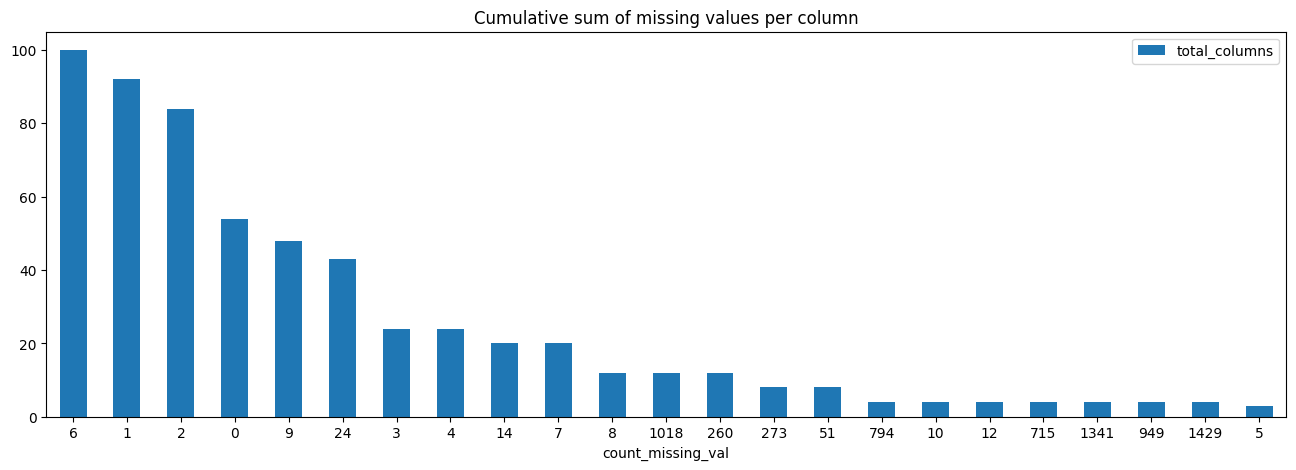

In [ ]:
# count missing values per each column
total_missing_col_count_df = raw_data_df.isna().sum().to_frame().reset_index()

# rename columns in data frame result
total_missing_col_count_df = total_missing_col_count_df.rename(columns={'index': 'features', 0: 'count_missing_val'})

# plot result
#total_missing_col_count_df.plot.bar(x='features', y='count_missing_val', rot=0)

# Compute cumulative sum of missing values
cumulative_sum_missing_values = total_missing_col_count_df.groupby(['count_missing_val']).size().reset_index(name='counts')
cumulative_sum_missing_values = cumulative_sum_missing_values.rename(columns={'count_missing_val': 'count_missing_val', 'counts': 'total_columns'})
cumulative_sum_missing_values = cumulative_sum_missing_values.sort_values(by=['total_columns'], ascending=False)

# compute rellative percentajes
total_columns = cumulative_sum_missing_values['total_columns'].sum()
cumulative_sum_missing_values['total_columns_relative(%)'] = cumulative_sum_missing_values['total_columns']/total_columns*100
cumulative_sum_missing_values = cumulative_sum_missing_values.reset_index(drop=True)
# compute cumulative sum by relative count
cumulative_sum_missing_values['cumulative_sum(%)'] = cumulative_sum_missing_values['total_columns_relative(%)'].cumsum(axis=0)

#print(cumulative_sum_missing_values)
pretty_table(cumulative_sum_missing_values)

# plot cumulative result
p = cumulative_sum_missing_values.plot.bar(x='count_missing_val', y='total_columns', rot=0, title='Cumulative sum of missing values per column', figsize=(16,5))
#p.bar_label(p)


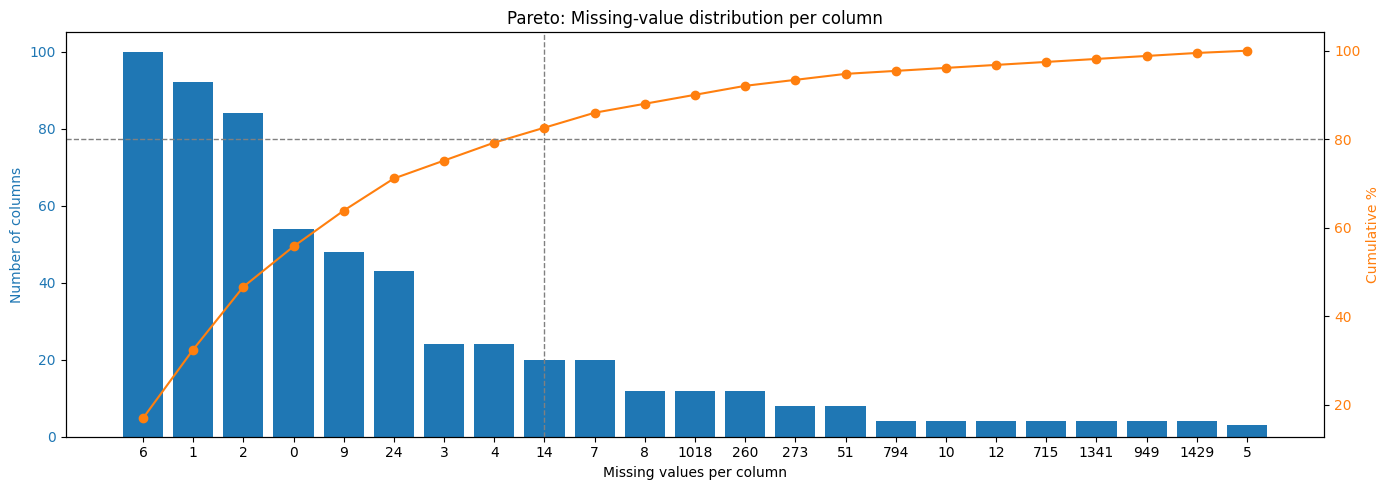

In [ ]:
# Pareto chart (reuse cumulative_sum_missing_values)
import matplotlib.pyplot as plt

# rename for convenience
pareto_df = cumulative_sum_missing_values.copy()

# ensure sorted by descending total_columns
pareto_df = pareto_df.sort_values('total_columns', ascending=False).reset_index(drop=True)

# strings for x‐axis
x = pareto_df['count_missing_val'].astype(str)

fig, ax1 = plt.subplots(figsize=(14,5))

# bar: number of columns
ax1.bar(x, pareto_df['total_columns'], color='C0', label='# columns')
ax1.set_xlabel('Missing values per column')
ax1.set_ylabel('Number of columns', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

# twin axis for cumulative %
ax2 = ax1.twinx()
ax2.plot(x, pareto_df['cumulative_sum(%)'], color='C1', marker='o', label='Cumulative %')
ax2.set_ylabel('Cumulative %', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

# draw 80% threshold line
ax2.axhline(80, color='grey', linestyle='--', linewidth=1)
# find first x where cum pct ≥80
idx80 = pareto_df[pareto_df['cumulative_sum(%)'] >= 80].index.min()
ax1.axvline(idx80, color='grey', linestyle='--', linewidth=1)

plt.title('Pareto: Missing‐value distribution per column')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### 2.2.2 Missing value per row

In [ ]:
# TODO: DO exactly as done for columns.
total_missing_row_count_df = raw_data_df.isnull().sum(axis = 1).to_frame().reset_index()
total_missing_row_count_df = total_missing_row_count_df.rename(columns={'index': 'rows', 0: 'count_missing_val'})

# Compute cumulative sum of missing values
cumulative_sum_missing_values_row = total_missing_row_count_df.groupby(['count_missing_val']).size().reset_index(name='counts')
cumulative_sum_missing_values_row = cumulative_sum_missing_values_row.rename(columns={'count_missing_val': 'count_missing_val', 'counts': 'total_rows'})
cumulative_sum_missing_values_row = cumulative_sum_missing_values_row.sort_values(by=['total_rows'], ascending=False)
pretty_table(cumulative_sum_missing_values_row)


+----+---------------------+--------------+
|    |   count_missing_val |   total_rows |
|----+---------------------+--------------|
|  9 |                  28 |          264 |
|  7 |                  24 |          239 |
|  5 |                  20 |          224 |
|  3 |                  16 |          170 |
|  2 |                  12 |          134 |
| 11 |                  32 |          132 |
| 13 |                  36 |          113 |
| 15 |                  40 |           75 |
| 17 |                  44 |           49 |
|  1 |                   8 |           49 |
| 19 |                  48 |           33 |
| 21 |                  52 |           12 |
|  0 |                   4 |            9 |
| 12 |                  35 |            8 |
| 23 |                  60 |            8 |
| 14 |                  39 |            5 |
| 10 |                  31 |            5 |
| 29 |                  84 |            4 |
| 24 |                  64 |            3 |
| 33 |                  96 |    

In [ ]:
# 2.1.3 Identify & flag features with >60% missing values

# 1. Compute missing‐value statistics for each feature
feature_missing_statistics = (
    raw_data_df
    .isna()
    .sum()
    .to_frame(name='missing_count')
    .reset_index()
    .rename(columns={'index': 'feature_name'})
)
feature_missing_statistics['missing_percentage'] = (
    feature_missing_statistics['missing_count']
    / len(raw_data_df)
    * 100
)

# 2. Select features where more than 60% of entries are missing
features_with_high_missingness = feature_missing_statistics[
    feature_missing_statistics['missing_percentage'] > 60
].sort_values('missing_percentage', ascending=False)

# 3. Display results
print("Features with more than 60% missing values:\n")
pretty_table(features_with_high_missingness)

print(f"\nTotal number of flagged features: {len(features_with_high_missingness)}")


Features with more than 60% missing values:

+-----+----------------+-----------------+----------------------+
|     | feature_name   |   missing_count |   missing_percentage |
|-----+----------------+-----------------+----------------------|
| 159 | f158           |            1429 |              91.1934 |
| 158 | f157           |            1429 |              91.1934 |
| 293 | f292           |            1429 |              91.1934 |
| 294 | f293           |            1429 |              91.1934 |
| 493 | f492           |            1341 |              85.5775 |
| 359 | f358           |            1341 |              85.5775 |
|  86 | f85            |            1341 |              85.5775 |
| 221 | f220           |            1341 |              85.5775 |
| 245 | f244           |            1018 |              64.9649 |
| 110 | f109           |            1018 |              64.9649 |
| 111 | f110           |            1018 |              64.9649 |
| 112 | f111           |       

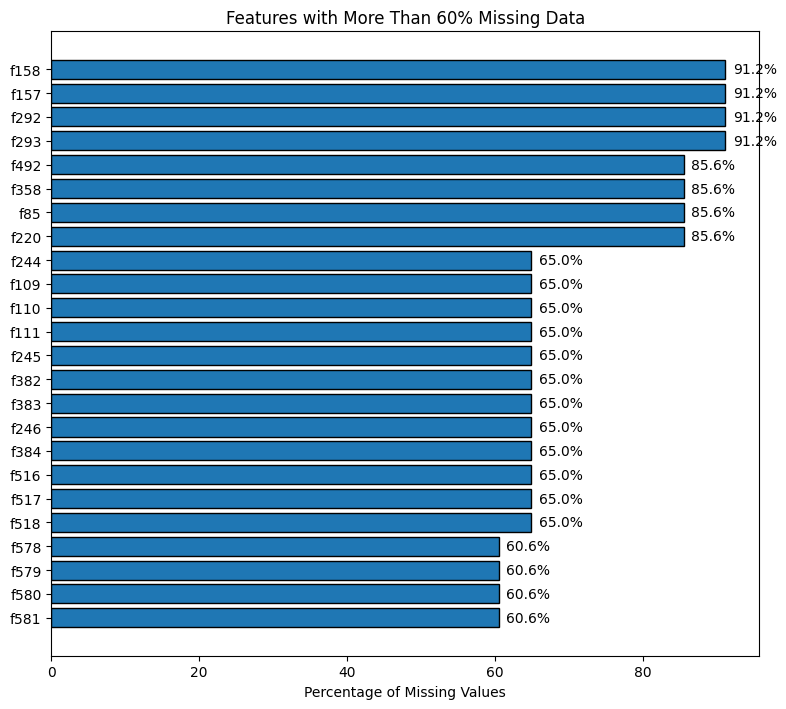

In [ ]:
# 2.1.4 Visualise features with >60% missing values

import matplotlib.pyplot as plt

# reuse the DataFrame from Cell 2.26
high_missing_df = features_with_high_missingness.copy()

# create horizontal bar chart
fig, ax = plt.subplots(figsize=(8, max(6, len(high_missing_df)*0.3)))
ax.barh(
    high_missing_df['feature_name'],
    high_missing_df['missing_percentage'],
    color='C0',
    edgecolor='k'
)
ax.set_xlabel('Percentage of Missing Values')
ax.set_title('Features with More Than 60% Missing Data')
ax.invert_yaxis()  # show highest percentages at the top

# annotate each bar with its missing % value
for idx, pct in enumerate(high_missing_df['missing_percentage']):
    ax.text(pct + 1, idx, f"{pct:.1f}%", va='center')

plt.tight_layout()
plt.show()


## 2.2 How many -1s and 1s?

In [ ]:
total_pass_count = raw_data_df['Pass/Fail'].value_counts().get(-1, 0)
total_fail_count = raw_data_df['Pass/Fail'].value_counts().get(1, 0)
total_samples = len(raw_data_df['Pass/Fail'])

dict_res = {'Values': ['-1 (Pass)', '1 (Fail)', 'Total'],
            'Absolute count(unit)': [total_pass_count, total_fail_count, total_samples],
            'Relative count(%)': [total_pass_count/total_samples*100,
                                   total_fail_count/total_samples*100,
                                   (total_fail_count + total_pass_count)/total_samples*100
                                  ]
            }
dict_res_df = pd.DataFrame(dict_res)

pretty_table(dict_res_df)

+----+-----------+------------------------+---------------------+
|    | Values    |   Absolute count(unit) |   Relative count(%) |
|----+-----------+------------------------+---------------------|
|  0 | -1 (Pass) |                   1463 |            93.3631  |
|  1 | 1 (Fail)  |                    104 |             6.63689 |
|  2 | Total     |                   1567 |           100       |
+----+-----------+------------------------+---------------------+


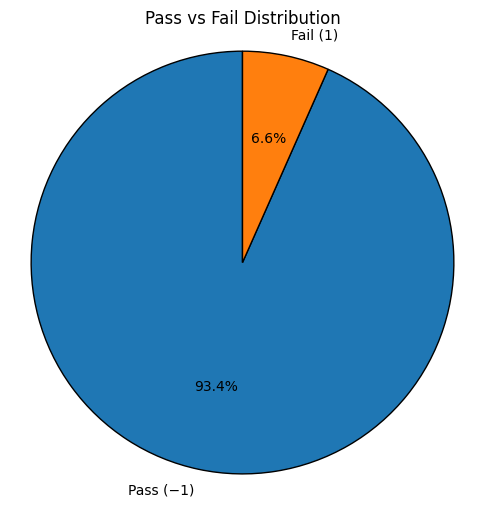

In [ ]:
#Pie chart of Pass vs Fail
import matplotlib.pyplot as plt

# compute counts
counts = raw_data_df['Pass/Fail'].value_counts().sort_index()
labels = ['Pass (−1)', 'Fail (1)']
sizes  = [counts.get(-1, 0), counts.get(1, 0)]

# plot
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'k'}
)
ax.axis('equal')  # keep as circle
ax.set_title("Pass vs Fail Distribution")
plt.show()

## 2.3 How many repeated rows?

In [ ]:
result_repeated_rows = pd.DataFrame(raw_data_df.iloc[:,1:-1].duplicated()).value_counts().get(True,0)
print(f"\nRepeated rows: {result_repeated_rows}")


Repeated rows: 0


In [ ]:
# 2.4 Approx. number of publications on SECOM dataset
import requests
r = requests.get('https://api.crossref.org/works?query=SECOM dataset&rows=0')
pubs = r.json()['message']['total-results']
print("≈ publications mentioning “SECOM dataset”:", pubs)


≈ publications mentioning “SECOM dataset”: 517743


3.1 Zero-nonzero variance

In [ ]:
# 3.1 Flag features with zero‐ and near‐zero variance

# 1. Define threshold for “near‐zero” variance
near_zero_variance_threshold = 1e-6

# 2. Compute variance of each numeric sensor (exclude the Pass/Fail target)
sensor_variances = (
    raw_data_df
    .select_dtypes(include='number')
    .drop(columns=['Pass/Fail'])
    .var()
)

# 3. Identify features with exactly zero variance and those just above zero
zero_variance_features = sensor_variances[sensor_variances == 0].index.to_list()
near_zero_variance_features = sensor_variances[
    (sensor_variances > 0) & (sensor_variances <= near_zero_variance_threshold)
].index.to_list()

# 4. Print counts and examples
print(f"Zero‐variance features:     {len(zero_variance_features)}")
print(f"Near‐zero‐variance features: {len(near_zero_variance_features)}\n")

print("Example zero‐variance features:")
print(zero_variance_features[:10], "\n")

print("Example near‐zero‐variance features:")
print(near_zero_variance_features[:10])


Zero‐variance features:     116
Near‐zero‐variance features: 11

Example zero‐variance features:
['f5', 'f13', 'f42', 'f49', 'f52', 'f69', 'f97', 'f141', 'f149', 'f178'] 

Example near‐zero‐variance features:
['f94', 'f95', 'f100', 'f101', 'f104', 'f278', 'f357', 'f358', 'f376', 'f377']


3.2 Outlier Detection

In [ ]:
# 3.2 Outlier detection by 3-sigma rule with thresholds and statistics

import pandas as pd

# 1. Prepare list to collect statistics
three_sigma_outlier_stats = []

# 2. Identify all numeric sensor columns (exclude the Pass/Fail target)
sensor_columns = (
    raw_data_df
    .select_dtypes(include='number')
    .drop(columns=['Pass/Fail'])
    .columns
)

# 3. Compute 3-sigma stats for each sensor
for sensor in sensor_columns:
    values = raw_data_df[sensor].dropna()
    mean_val = values.mean()
    std_val  = values.std()
    lower_limit = mean_val - 3 * std_val
    upper_limit = mean_val + 3 * std_val

    # calculate percentage of outliers beyond ±3σ
    outlier_pct = ((values < lower_limit) | (values > upper_limit)).mean() * 100

    three_sigma_outlier_stats.append({
        'feature_name': sensor,
        'mean': mean_val,
        'std_dev': std_val,
        '3sigma_lower_bound': lower_limit,
        '3sigma_upper_bound': upper_limit,
        'outlier_pct_3sigma': outlier_pct
    })

# 4. Build DataFrame and sort descending by outlier percentage
three_sigma_outlier_df = (
    pd.DataFrame(three_sigma_outlier_stats)
      .sort_values(by='outlier_pct_3sigma', ascending=False)
      .reset_index(drop=True)
)

# 5. Display the top 10 sensors by outlier rate
print("Top 10 sensors by 3-sigma outlier percentage (with thresholds):\n")
pretty_table(three_sigma_outlier_df.head(10))


Top 10 sensors by 3-sigma outlier percentage (with thresholds):

+----+----------------+------------+-------------+----------------------+----------------------+----------------------+
|    | feature_name   |       mean |     std_dev |   3sigma_lower_bound |   3sigma_upper_bound |   outlier_pct_3sigma |
|----+----------------+------------+-------------+----------------------+----------------------+----------------------|
|  0 | f38            |  86.8366   |   0.446756  |           85.4963    |            88.1768   |              4.53384 |
|  1 | f576           |   5.56375  |  16.9214    |          -45.2004    |            56.3279   |              4.46713 |
|  2 | f574           |   9.16231  |  26.9202    |          -71.5981    |            89.9228   |              4.3395  |
|  3 | f577           |  16.6424   |  12.4853    |          -20.8134    |            54.0982   |              3.9566  |
|  4 | f573           |   0.345636 |   0.248478  |           -0.399798  |             1.09107  

# 3 Data Splitting : Cross Validation

## 3.1 K-Fold

In [ ]:
raw_data_df.columns



Index(['Time', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       ...
       'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589',
       'Pass/Fail'],
      dtype='object', length=592)

In [ ]:
X = raw_data_df.drop(columns=['Pass/Fail','Time'])  # Features
y = raw_data_df['Pass/Fail']  # Target column

# Initialize k-fold
kf = KFold(n_splits=10)

# Create an empty DataFrame to store proportions for each fold
fold_results = []

# Iterate through each fold
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    # Get training and test target values
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    # Calculate train proportions
    train_proportions = y_train.value_counts(normalize=True) * 100
    for target, proportion in train_proportions.items():
        fold_results.append({'Set': 'Train', 'Fold': f'Fold {fold}', 'Target': target, 'Proportion': proportion})

    # Calculate test proportions
    test_proportions = y_test.value_counts(normalize=True) * 100
    for target, proportion in test_proportions.items():
        fold_results.append({'Set': 'Test', 'Fold': f'Fold {fold}', 'Target': target, 'Proportion': proportion})

# Convert the results to a DataFrame
results_df_k = pd.DataFrame(fold_results)

print(results_df_k.head())

     Set    Fold  Target  Proportion
0  Train  Fold 1      -1   94.042553
1  Train  Fold 1       1    5.957447
2   Test  Fold 1      -1   87.261146
3   Test  Fold 1       1   12.738854
4  Train  Fold 2      -1   94.326241


##3.2 Stratified K-Fold

In [ ]:
X = raw_data_df.drop(columns=['Pass/Fail','Time'])  # Features
y = raw_data_df['Pass/Fail']  # Target column

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10)

# Create an empty DataFrame to store proportions for each fold
fold_results = []

# Iterate through each stratified fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y), start=1):
    # Get training and test target values
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    # Calculate train proportions
    train_proportions = y_train.value_counts(normalize=True) * 100
    for target, proportion in train_proportions.items():
        fold_results.append({'Set': 'Train', 'Fold': f'Fold {fold}', 'Target': target, 'Proportion': proportion})

    # Calculate test proportions
    test_proportions = y_test.value_counts(normalize=True) * 100
    for target, proportion in test_proportions.items():
        fold_results.append({'Set': 'Test', 'Fold': f'Fold {fold}', 'Target': target, 'Proportion': proportion})

# Convert the results to a DataFrame
results_df_k_stratified = pd.DataFrame(fold_results)

print(results_df_k_stratified.head())

     Set    Fold  Target  Proportion
0  Train  Fold 1      -1   93.333333
1  Train  Fold 1       1    6.666667
2   Test  Fold 1      -1   93.630573
3   Test  Fold 1       1    6.369427
4  Train  Fold 2      -1   93.333333


## 3.3 Comparision of K-Fold and Stratified K-Fold

In [ ]:
# Combining K-Fold and stratified K-Fold results
results_df_k_stratified['cross_tech'] = 'stratified K-Fold'
results_df_k['cross_tech'] = 'K-Fold'

results = pd.concat([results_df_k, results_df_k_stratified], ignore_index=True)

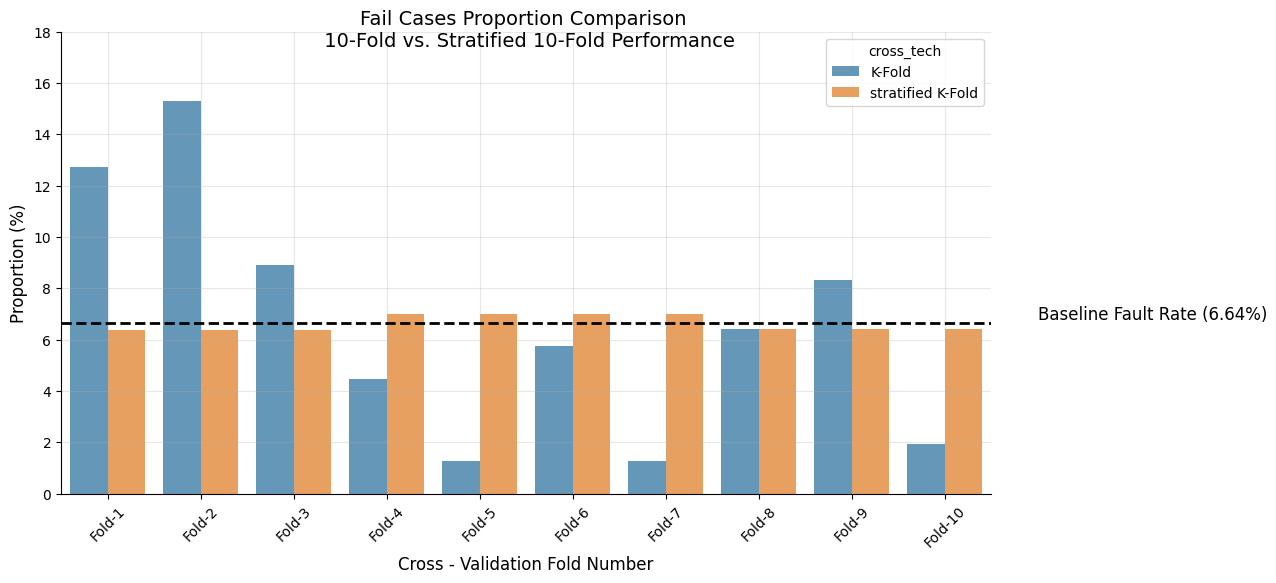

In [ ]:
# Convert Fold to numerical and categorical for proper plotting
results['Fold_Num'] = results['Fold'].str.extract('(\d+)').astype(int).astype(str)

plt.figure(figsize=(12, 6))

# Plot bar chart with categorical x-axis
ax = sns.barplot(x='Fold_Num', y='Proportion', hue='cross_tech',
                 data=results[(results['Target']==1) & (results['Set']=='Test')],  alpha=0.75)

# Add horizontal reference line
plt.axhline(y=6.64, color='black', linestyle='--', linewidth=2)

# Add text near reference line
plt.text(x=len(results['Fold_Num'].unique()), y=6.64,
         s="Baseline Fault Rate (6.64%)", color='black', fontsize=12, verticalalignment='bottom')

sns.despine()
plt.ylim(0, 18)
plt.title('Fail Cases Proportion Comparison \n 10-Fold vs. Stratified 10-Fold Performance', fontsize=14, y=0.95)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xlabel('Cross - Validation Fold Number', fontsize=12)

# Correct x-tick alignment
plt.xticks(
    ticks=ax.get_xticks(),  # Get Seaborn-defined tick positions
    labels=[f"Fold-{i}" for i in sorted(results['Fold_Num'].astype(int).unique())],
    ha='center', rotation=45
)

# Adjust x-axis limits to prevent shifting
plt.xlim(-0.5, len(results['Fold_Num'].unique()) - 0.5)
plt.grid(True, alpha=0.3);

# 4. Data Cleaning : Training Set

In [ ]:
X = raw_data_df.drop(columns=['Pass/Fail','Time'])  # Features
y = raw_data_df['Pass/Fail']  # Target column


# Zero Volatility Columns
def zero_voltality_cols(X_train):
    return [col for col in X_train.columns if X_train[col].nunique() == 1]

# Low Volatality Columns

def low_volatality_cols(X_train):
    std_dev = X_train.std()
    variance = X_train.var()
    return X_train.columns[variance<1e-6].tolist()


# Missing values >60%
def missing_values(X_train):
    missing_values = X_train.isnull().sum() / X_train.shape[0] * 100
    return missing_values[missing_values > 60].index.tolist()

def outliers(X_train, threshold):
    means = X_train.mean()
    stds = X_train.std()

    # Define Outlier Boundaries
    upper_bound = means + (threshold * stds)
    lower_bound = means - (threshold * stds)
    # Identify outliers but retain them for imputation
    outlier_values = (X_train < lower_bound) | (X_train > upper_bound)
    return outlier_values


# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # print(X_train.shape)

    # Zero Volatility Columns
    zero_voltality_cols = zero_voltality_cols(X_train)
    print("Count of Zero Volatality Cols:",len(zero_voltality_cols))
    X_train = X_train.drop(columns=zero_voltality_cols)

     # Low Valatality columns : No Action
    low_volatality_cols = low_volatality_cols(X_train)
    print("Count of Low Volatality Cols:", len(low_volatality_cols))

    # Missing Values > 60%
    missing_values = missing_values(X_train)
    print("Count of Missing Vlaues(>60%) Cols:",len(missing_values))
    X_train = X_train.drop(columns=missing_values)
    # X_train.to_csv('X_train.csv')

    # Outliers Detection
    threshold = 4
    outliers_values = outliers(X_train, threshold)
    total_outliers = outliers_values.sum().sum()
#   total count of values in training dataset
    total_datapoints = X_train.size
    # Compute proportion of outliers
    outlier_proportion = total_outliers / total_datapoints


#     print(X_train[outliers_values])
    print(f"Total Rows:", len(X_train))
    print(f"Rows with at least one outlier ({threshold}S Rule): {outliers_values.any(axis=1).sum()}")
    print(f"Total outliers ({threshold}S Rule): {total_outliers}")
    print(f"Outlier proportion ({threshold}S Rule): {outlier_proportion:.4f} ({outlier_proportion * 100:.2f}%)")

    break #calculates only for the first fold



Count of Zero Volatality Cols: 116
Count of Low Volatality Cols: 11
Count of Missing Vlaues(>60%) Cols: 24
Total Rows: 1410
Rows with at least one outlier (4S Rule): 687
Total outliers (4S Rule): 2917
Outlier proportion (4S Rule): 0.0046 (0.46%)
